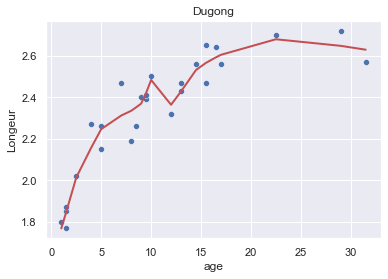

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, truncnorm, uniform
import statsmodels.api as sm

# Data
X = np.array([1, 1.5, 1.5, 1.5, 2.5, 4, 5, 5, 7, 8, 8.5, 9, 9.5, 9.5, 10,
              12, 12, 13, 13, 14.5, 15.5, 15.5, 16.5, 17, 22.5, 29, 31.5])

Y = np.array([1.8, 1.85, 1.87, 1.77, 2.02, 2.27, 2.15, 2.26, 2.47, 2.19,
              2.26, 2.4, 2.39, 2.41, 2.5, 2.32, 2.32, 2.43, 2.47, 2.56, 2.65,
              2.47, 2.64, 2.56, 2.7, 2.72, 2.57])

data = pd.DataFrame({"X": X, "Y": Y})

lowess = sm.nonparametric.lowess
smoothed_points = lowess(data["Y"], data["X"], frac=0.3)

sns.set_theme()
sns.scatterplot(x="X", y="Y", data=data)
plt.plot(smoothed_points[:, 0], smoothed_points[:, 1], 'r-', lw=2)
plt.title("Dugong")
plt.xlabel("age")
plt.ylabel("Longeur")
plt.show()

def logit(x):
    return np.log(x / (1 - x))

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

In [36]:
def gibbs_sampling(age, Y, nchain=10**4, prop_sd=np.array([0.01, 0.1, 1, 0.01])):
    init = np.array([2, 1, 11, 0.9])
    chain = np.empty((nchain + 1, 4))
    chain[0, :] = init
    n = len(Y)
    sig = 1000

    for iter in range(nchain):
        current = chain[iter, :]

        # Update alpha
        prop = current.copy()
        prop[0] = np.random.lognormal(np.log(current[0]), prop_sd[0])
        kernel_ratio = prop[0] / current[0]

        top = np.sum(norm.logpdf(Y, prop[0] - current[1] * current[3] ** age, 1 / np.sqrt(current[2]))) + \
            norm.logpdf(prop[0], 0, sig)
        bottom = np.sum(norm.logpdf(Y, current[0] - current[1] * current[3] ** age, 1 / np.sqrt(current[2]))) + \
            norm.logpdf(current[0], 0, sig)

        acc_prob = np.exp(top - bottom) * kernel_ratio

        if np.random.uniform() < acc_prob:
            current = prop.copy()

        # Update beta
        prop = current.copy()
        prop[1] = np.random.lognormal(np.log(current[1]), prop_sd[1])
        kernel_ratio = prop[1] / current[1]

        top = np.sum(norm.logpdf(Y, current[0] - prop[1] * current[3] ** age, 1 / np.sqrt(current[2]))) + \
            norm.logpdf(prop[1], 0, sig)
        bottom = np.sum(norm.logpdf(Y, current[0] - current[1] * current[3] ** age, 1 / np.sqrt(current[2]))) + \
            norm.logpdf(current[1], 0, sig)

        acc_prob = np.exp(top - bottom) * kernel_ratio

        if np.random.uniform() < acc_prob:
            current = prop.copy()

        # Update tau
        prop = current.copy()
        prop[2] = np.random.lognormal(np.log(current[2]), prop_sd[2])

        kernel_ratio = prop[2] / current[2]

        top = np.sum(norm.logpdf(Y, current[0] - current[1] * current[3] ** age, 1 / np.sqrt(prop[2]))) + \
            gamma.logpdf(prop[2], a=0.001, scale=1/0.001)
        bottom = np.sum(norm.logpdf(Y, current[0] - current[1] * current[3] ** age, 1 / np.sqrt(current[2]))) + \
            gamma.logpdf(current[2], a=0.001, scale=1/0.001)

        acc_prob = np.exp(top - bottom) * kernel_ratio

        if np.random.uniform() < acc_prob:
            current = prop.copy()

        # Update gamma
        prop = current.copy()
        prop[3] = np.random.lognormal(np.log(current[3]), prop_sd[3])

        kernel_ratio = prop[3] / current[3]
        top = np.sum(norm.logpdf(Y, current[0] - current[1] * prop[3] ** age, 1 / np.sqrt(current[2]))) + \
            uniform.logpdf(prop[3], 0.5, 0.5)
        bottom = np.sum(norm.logpdf(Y, current[0] - current[1] * current[3] ** age, 1 / np.sqrt(current[2]))) + \
            uniform.logpdf(current[3], 0.5, 0.5)

        acc_prob = np.exp(top - bottom) * kernel_ratio

        if np.random.uniform() < acc_prob and prop[3] < 1:
            current = prop.copy()

        # Save the new state
        chain[iter + 1, :] = current

    return chain







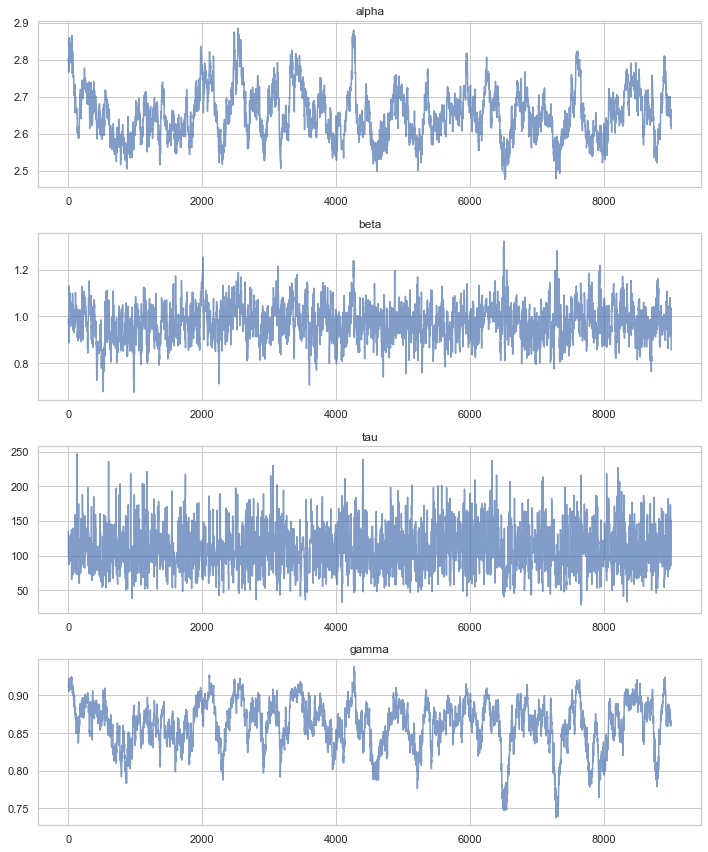

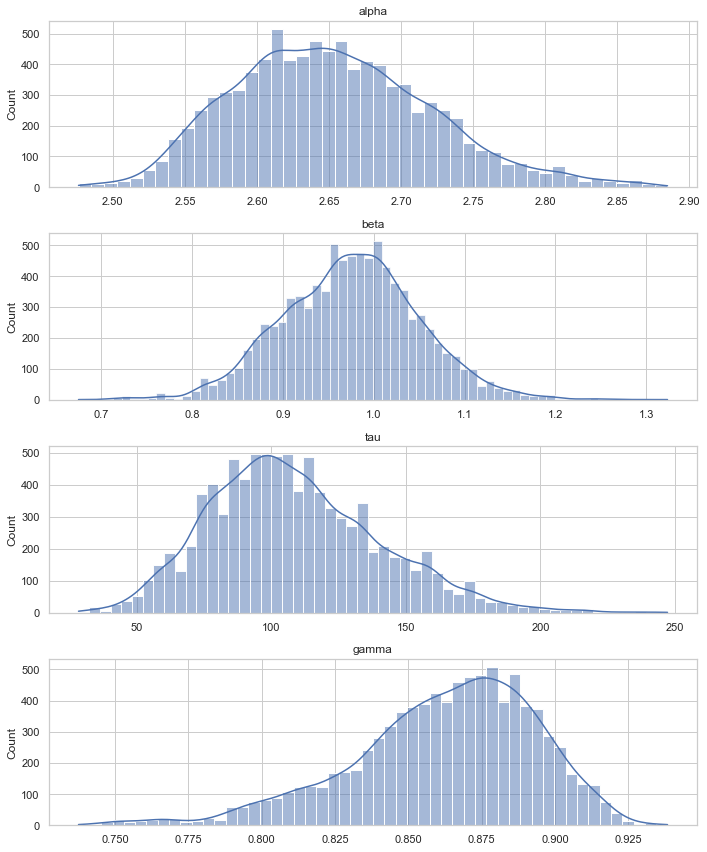

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

nchain = 10000
chain = gibbs_sampling(X, Y, nchain)

# Remove burning period
burn_in = 1000
chain = chain[burn_in:]

# Set the style for the plots
sns.set(style="whitegrid")

param_names = ['alpha', 'beta', 'tau', 'gamma']

def plot_trace(chains, param_names):
    n_params = len(param_names)
    fig, axes = plt.subplots(n_params, 1, figsize=(10, 3 * n_params))

    for idx, ax in enumerate(axes):
        ax.plot(chains[:, idx], alpha=0.7)
        ax.set_title(param_names[idx])

    plt.tight_layout()
    plt.show()

def plot_histograms(chains, param_names):
    n_params = len(param_names)
    fig, axes = plt.subplots(n_params, 1, figsize=(10, 3 * n_params))

    for idx, ax in enumerate(axes):
        sns.histplot(chains[:, idx], kde=True, ax=ax)
        ax.set_title(param_names[idx])

    plt.tight_layout()
    plt.show()

plot_trace(chain, param_names)
plot_histograms(chain, param_names)




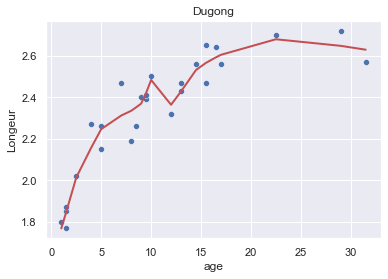

In [38]:
lowess = sm.nonparametric.lowess
smoothed_points = lowess(data["Y"], data["X"], frac=0.3)
sns.set_theme()
sns.scatterplot(x="X", y="Y", data=data)
plt.plot(smoothed_points[:, 0], smoothed_points[:, 1], 'r-', lw=2)
plt.title("Dugong")
plt.xlabel("age")
plt.ylabel("Longeur")
plt.show()

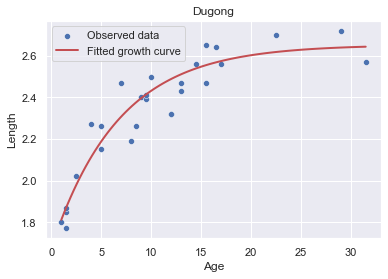

Predicted length for a dugong of age 20: 2.60


In [39]:
# Fitted growth curve
def fitted_growth_curve(age, alpha, beta, gamma):
    return alpha - beta * gamma ** age

# Mean values of the parameters
mean_alpha = np.mean(chain[:, 0])
mean_beta = np.mean(chain[:, 1])
mean_gamma = np.mean(chain[:, 3])


# Plot the observed data and the fitted growth curve
sns.scatterplot(x="X", y="Y", data=data, label="Observed data")
age_range = np.linspace(X.min(), X.max(), 100)
plt.plot(age_range, fitted_growth_curve(age_range, mean_alpha, mean_beta, mean_gamma), 'r-', lw=2, label="Fitted growth curve")
plt.title("Dugong")
plt.xlabel("Age")
plt.ylabel("Length")
plt.legend()
plt.show()

# Predict the length of a new dugong with a given age
new_age = 20
predicted_length = fitted_growth_curve(new_age, mean_alpha, mean_beta, mean_gamma)
print(f"Predicted length for a dugong of age {new_age}: {predicted_length:.2f}")


        count      mean       std       min       25%       50%       75%  \
alpha  9001.0  2.652410  0.068096  2.476143  2.603128  2.647727  2.696215   
beta   9001.0  0.975107  0.075485  0.675230  0.923918  0.976362  1.023637   
sigma  9001.0  0.099157  0.015153  0.063602  0.088379  0.097714  0.107791   
gamma  9001.0  0.862104  0.031580  0.737502  0.844278  0.866400  0.884915   

            max  
alpha  2.884738  
beta   1.323257  
sigma  0.187582  
gamma  0.938387  


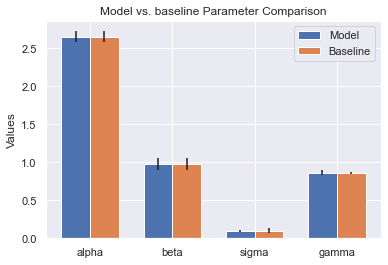

In [40]:
results = pd.DataFrame()
results['alpha']=chain[:, 0]
results['beta']=chain[:, 1]
results['sigma']=1/np.sqrt(chain[:, 2])
results['gamma']=chain[:, 3]

def plot_parameter_comparison(params_df):
    ind = np.arange(len(params_df))  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind - width / 2, params_df['mean'], width, label='Model', yerr=params_df['std'])
    rects2 = ax.bar(ind + width / 2, params_df['mean_base'], width, label='Baseline', yerr=params_df['std_base'])

    ax.set_ylabel('Values')
    ax.set_title('Model vs. baseline Parameter Comparison')
    ax.set_xticks(ind)
    ax.set_xticklabels(['alpha', 'beta', 'sigma', 'gamma'])
    ax.legend()

    plt.show()

results_summary = results.describe().T
print(results_summary)

params_df = pd.DataFrame()
params_df['mean'] = results_summary['mean']
params_df['std'] = results_summary['std']
#Carlin and Gelfand estimates
params_df['mean_base'] = [2.652, 0.9729 , 0.0992 , 0.8623 ]
params_df['std_base'] = [0.07094, 0.07649, 0.03259, 0.01496]
params_df.reset_index(drop=True, inplace=True)

plot_parameter_comparison(params_df)